### Projection analysis: 
Look at projections of neural activity for a specific feature

Is  rule representation just red representation with a higher amplitude?

Condition trials on: 
- specific feature selected
- correct trials

Grouped by: 
- more/less pos RPE
- is max value or not

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
from utils.session_data import SessionData
import utils.io_utils as io_utils
from utils.constants import *
import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression

In [4]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

set feature for consideration

In [5]:
FEATURE = "MAGENTA"
MIN_NUM_TRIALS = 20
CONDITIONS = ["MaxFeatMatches", "RPEGroup"]
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
REGION = "all"

In [6]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
units = spike_utils.get_unit_positions(valid_sess)
# region_units = units[units.manual_structure == "Prefrontal Cortex"]
# region_units = units[units.structure_level2 == REGION]
# region_units = units[units.structure_level3 == REGION]

region_units = units

### Step 1: Find trial labels, balance the sessions, join with FRs

get all sessions with behavioral model fits

In [7]:
# NOTE: maybe don't balance for now, 
def validate_and_label_sessions(row, feature, region_units):
    # check region specificity:
    # if not row.session_name in region_units.session.values:
    #     return None
    labeled_beh = behavioral_utils.get_beh_model_labels_for_session_feat(row.session_name, feature)
    labeled_beh = labeled_beh[labeled_beh.Response == "Correct"]
    enough_trials = behavioral_utils.validate_enough_trials_by_condition(labeled_beh, CONDITIONS, MIN_NUM_TRIALS, num_unique_conditions=4)
    if not enough_trials:
        return None
    frs_path = SESS_SPIKES_PATH.format(
        sess_name=row.session_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(frs_path)
    frs["PseudoUnitID"] = int(row.session_name) * 100 + frs["UnitID"]
    frs = frs[frs.PseudoUnitID.isin(region_units.PseudoUnitID)]
    merged = pd.merge(labeled_beh, frs, on="TrialNumber")
    if len(merged) == 0:
        return None
    return merged


In [8]:
valid_sessions = pd.read_pickle(SESSIONS_PATH)

In [9]:
res = valid_sessions.apply(lambda x: validate_and_label_sessions(x, FEATURE, region_units), axis=1)
res = res.dropna()
all_trials = pd.concat(res.values)
all_trials["Condition"] = all_trials.MaxFeatMatches.astype(str) + " " + all_trials.RPEGroup
conditions = all_trials.Condition.unique()
conditions.sort()

### Print some stats about the all the trials/sessions

In [10]:
print(f"Number of sessions: {len(all_trials.Session.unique())}")
print(f"Number of neurons total: {len(all_trials.PseudoUnitID.unique())}")

Number of sessions: 16
Number of neurons total: 403


In [11]:
base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("BaseFiringRate").reset_index()
conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()

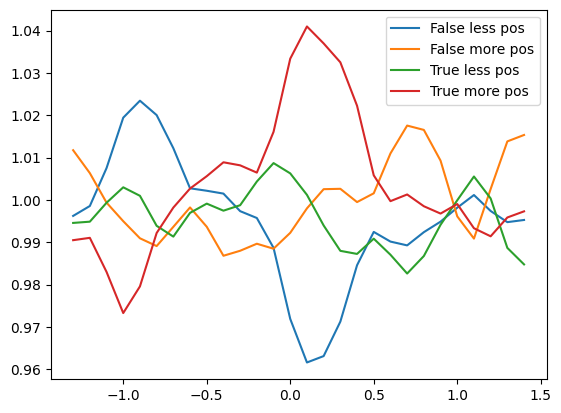

In [12]:
fig, ax = plt.subplots()
for condition in conditions:
    frs = conditioned_frs[conditioned_frs.Condition == condition]
    merged = pd.merge(frs, base_frs, on=["PseudoUnitID", "TimeBins"])
    def calc_proj(group):
        prod = group.ConditionedFiringRate * group.BaseFiringRate
        # base_mag = np.sqrt(np.sum(group.BaseFiringRate ** 2))
        base_mag = np.sum(group.BaseFiringRate ** 2)
        dot = np.sum(prod)
        proj = dot / base_mag
        return proj
    res = merged.groupby("TimeBins").apply(calc_proj).to_frame("Proj").reset_index()
    time = np.arange(-1.3, 1.5, 0.1)
    ax.plot(time, res.Proj, label=condition)
ax.legend()

### Look at some RSM Matrices

In [13]:
RPE_MATRIX = {
    "False less pos : False more pos": 0,
    "False less pos : True less pos": 1,
    "False less pos : True more pos": 0,
    "False more pos : True less pos": 0,
    "False more pos : True more pos": 1,
    "True less pos : True more pos": 0,
}
MAX_MATRIX = {
    "False less pos : False more pos": 1,
    "False less pos : True less pos": 0,
    "False less pos : True more pos": 0,
    "False more pos : True less pos": 0,
    "False more pos : True more pos": 0,
    "True less pos : True more pos": 1,
}
RULE_MATRIX = {
    "False less pos : False more pos": 1,
    "False less pos : True less pos": 0,
    "False less pos : True more pos": 1,
    "False more pos : True less pos": 0,
    "False more pos : True more pos": 1,
    "True less pos : True more pos": 0,
}

# time_bins = [0.3, 0.6, 1.0, 1.5, 1.8]
def get_cor_mats(conditioned_frs, time_bins):
    cor_mats = []
    for time_bin in time_bins:
        cors = np.empty((4, 4))
        frs_time = conditioned_frs[np.isclose(conditioned_frs.TimeBins, time_bin)]
        for i, cond_i in enumerate(conditions):
            for j, cond_j in enumerate(conditions):
                frs_i = frs_time[frs_time.Condition == cond_i].sort_values(by="PseudoUnitID")
                frs_j = frs_time[frs_time.Condition == cond_j].sort_values(by="PseudoUnitID")

                coefs = np.corrcoef([frs_i.ConditionedFiringRate.values, frs_j.ConditionedFiringRate.values])
                cors[i, j] = coefs[0, 1]
        cor_mats.append(cors)
    return cor_mats

def get_data_df(cor_mats, time_bins):
    rows = []
    for time_idx, time_bin in enumerate(time_bins):
        for i, cond_i in enumerate(conditions):
            for j, cond_j in enumerate(conditions):
                if i < j:
                    cond_comb = f"{cond_i} : {cond_j}"
                    rows.append({
                        "CondComb": cond_comb,
                        "TimeBins": time_bin,
                        "TimeBinIdx": time_idx,
                        "Y": cor_mats[time_idx][i, j],
                        "RPE": RPE_MATRIX[cond_comb],
                        "Max": MAX_MATRIX[cond_comb],
                        "Rule": RULE_MATRIX[cond_comb],
                    })
    data_df = pd.DataFrame(rows)
    return data_df

def calc_partial_coef(group, all_vars, var):
    ys = group.Y.values.reshape(-1, 1)
    red_vars = [v for v in all_vars if not v == var]
    xs_red = group[red_vars].values
    xs_full = group[all_vars].values
    # print(xs_full.shape)
    reg_red = LinearRegression().fit(ys, xs_red)
    rsquared_red = reg_red.score(ys, xs_red)
    reg_full = LinearRegression().fit(ys, xs_full)
    rsquared_full = reg_full.score(ys, xs_full)
    partial_coef =  1 - (1 - rsquared_full) / (1 - rsquared_red)
    # print(f"{group.name}: reduced R^2: {rsquared_red}, full R^2: {rsquared_full}, partial coef: {partial_coef}")
    return partial_coef
    

### Try regression using design matrices

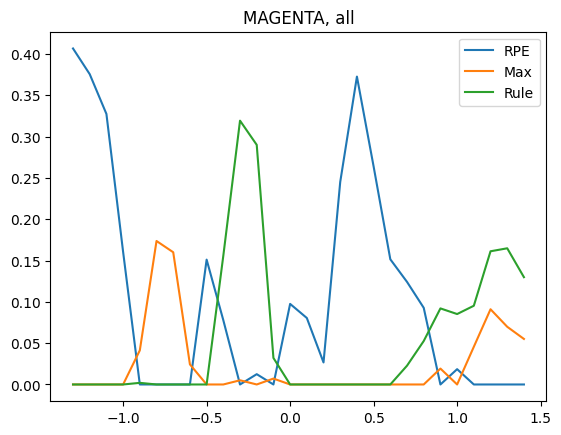

In [15]:
both_vars = ["RPE", "Max"]
all_vars = ["RPE", "Max", "Rule"]
time_bins = np.arange(0, 2.8, 0.1)
cor_mats = get_cor_mats(conditioned_frs, time_bins)
data_df = get_data_df(cor_mats, time_bins)

rpe_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, both_vars, "RPE"))
max_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, both_vars, "Max"))
rule_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, all_vars, "Rule"))

fig, ax = plt.subplots()
ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(rpe_partial_coef.values, np.zeros(len(res))), label="RPE")
ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(max_partial_coef.values, np.zeros(len(res))), label="Max")
ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(rule_partial_coef.values, np.zeros(len(res))), label="Rule")

# plt.plot(np.arange(-1.3, 1.5, 0.05), res.values)
ax.set_title(f"{FEATURE}, {REGION}")
ax.legend()

Text(0.5, 1.0, 'Time Bin -0.6000000000000001')

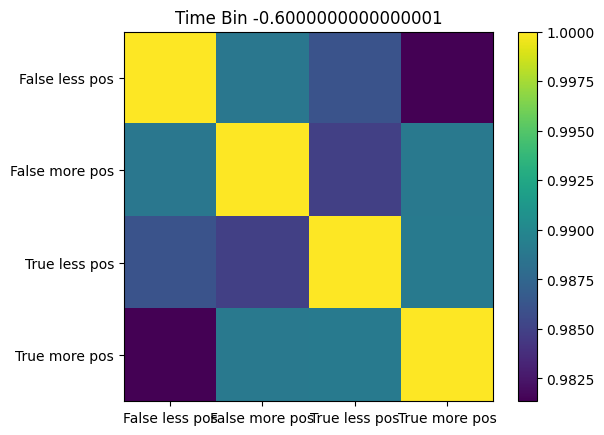

In [16]:
time_bin = 0.7
time_bin_idx = int(time_bin / 0.1)
cors = cor_mats[time_bin_idx]
fig, ax = plt.subplots()
colors = ax.matshow(cors)
fig.colorbar(colors)
tick_pos = np.arange(0, 4)
ax.set_xticks(tick_pos)
ax.set_xticklabels(conditions)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(conditions)
ax.set_title(f"Time Bin {time_bin - 1.3}")

### Make a function for this, go through each feature, plot for all units, HC units, OFC units, latPFC units. 

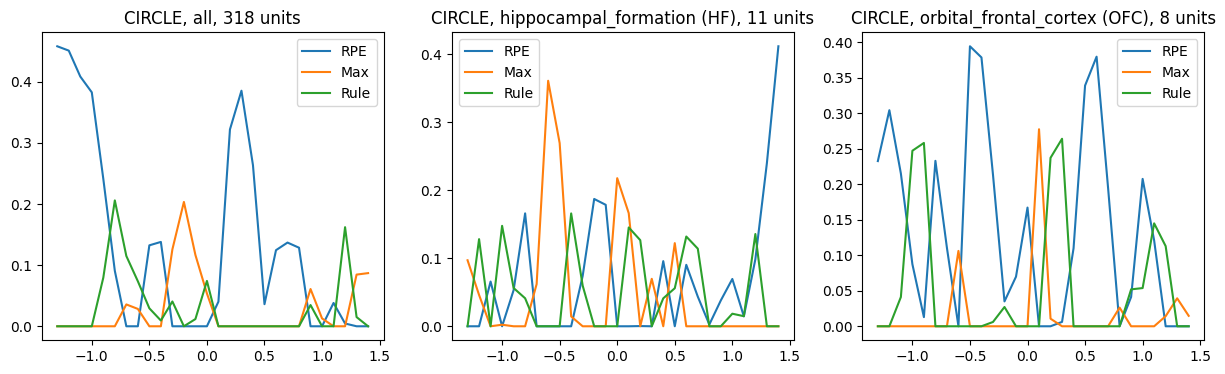

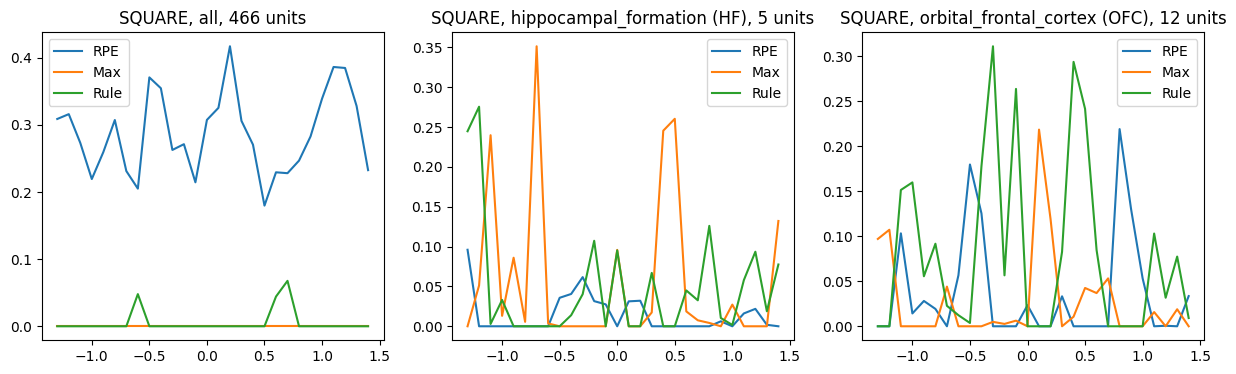

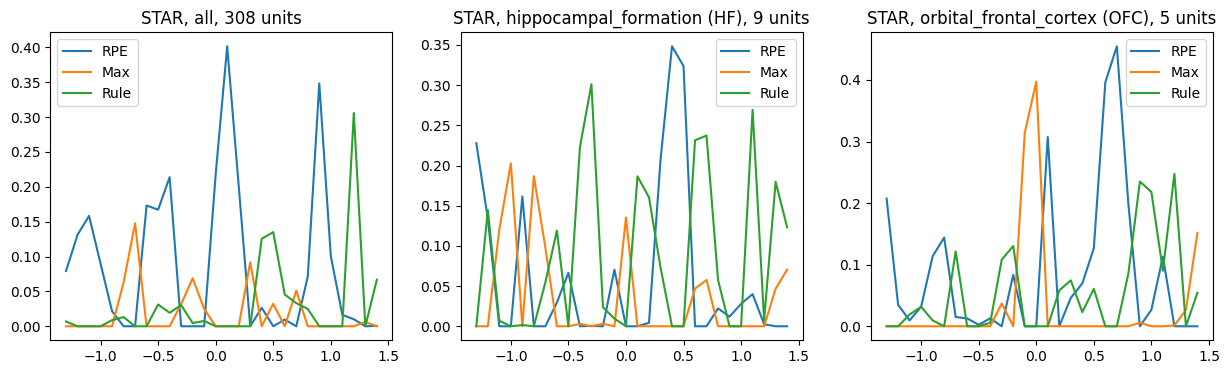

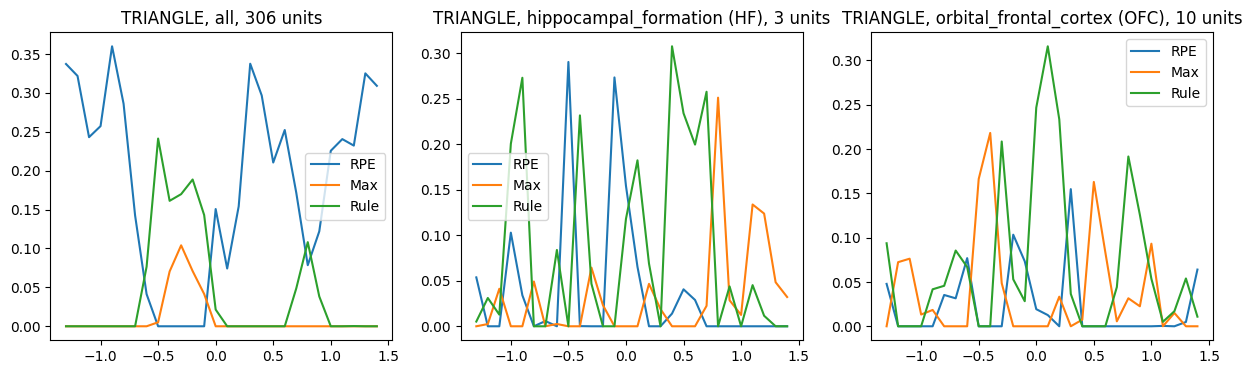

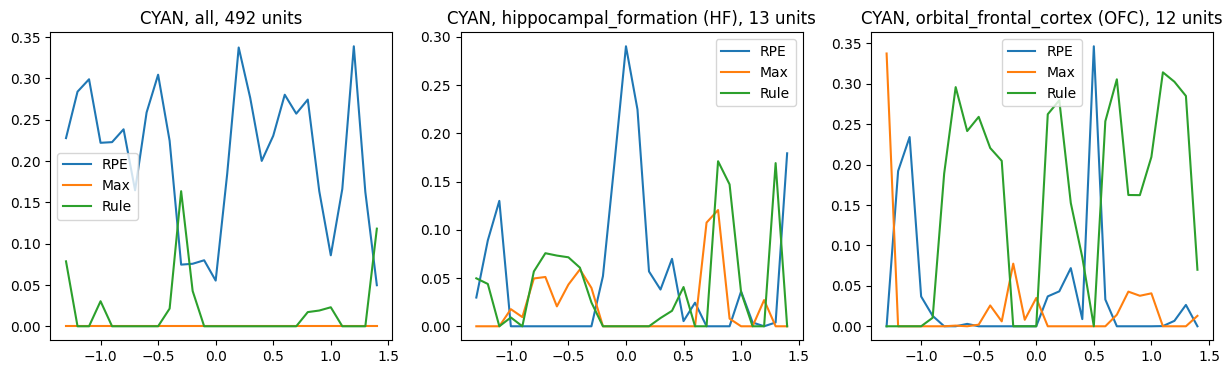

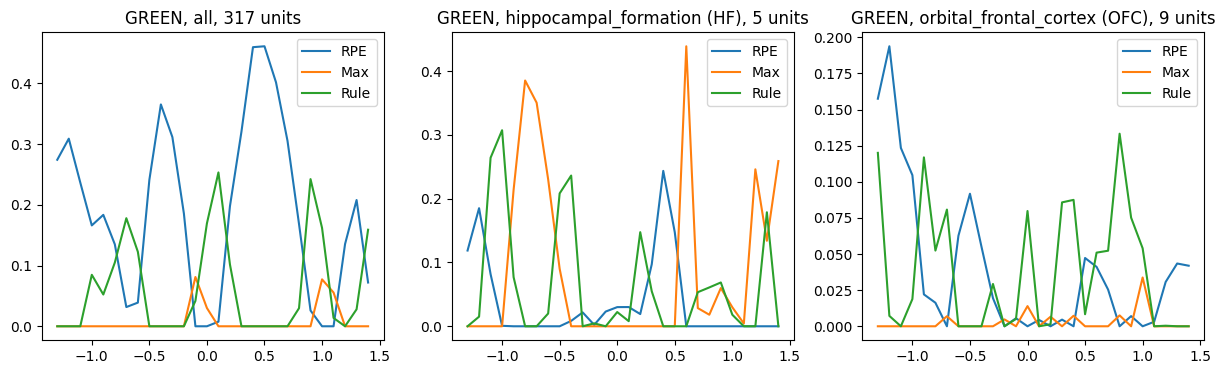

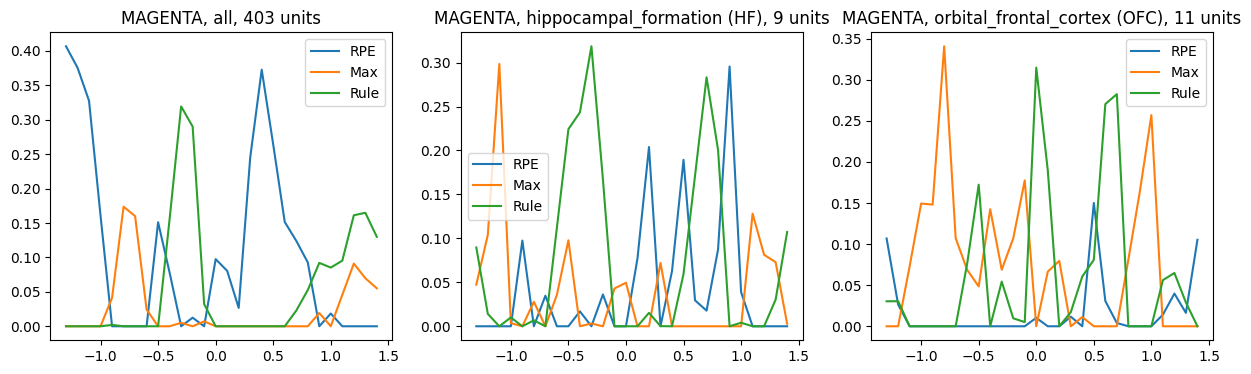

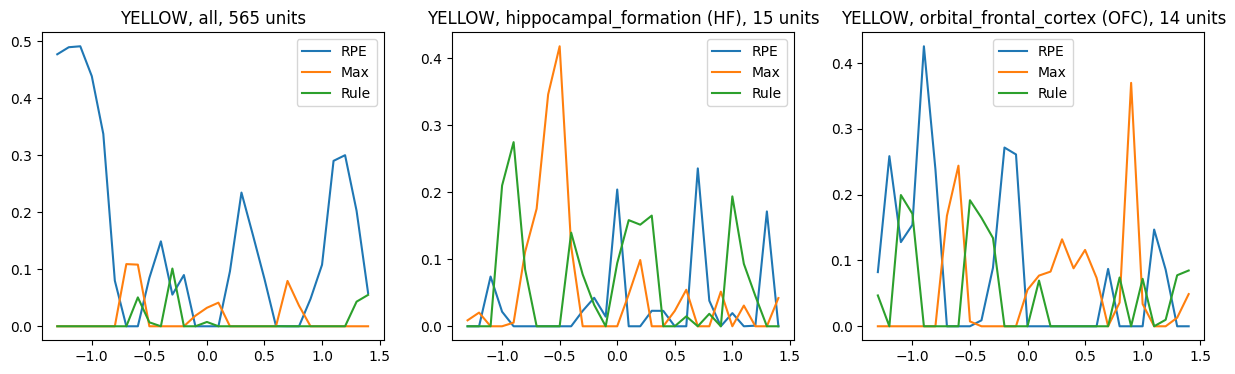

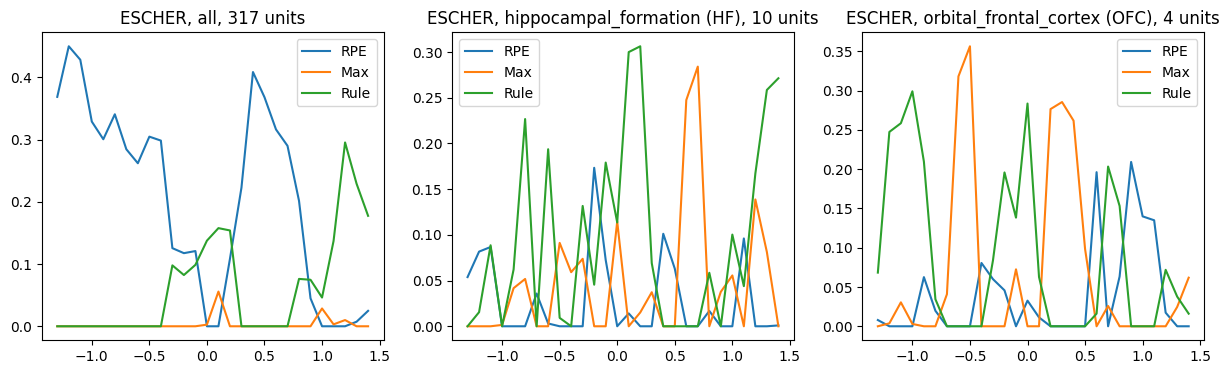

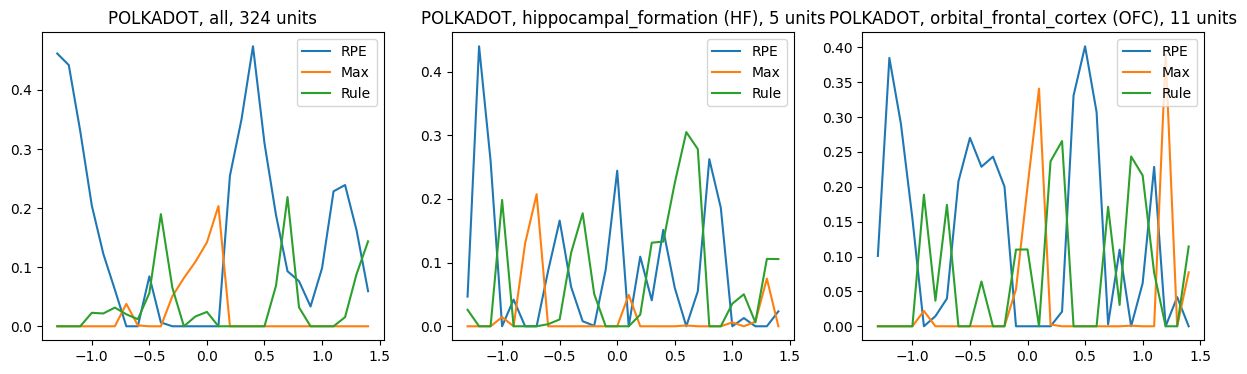

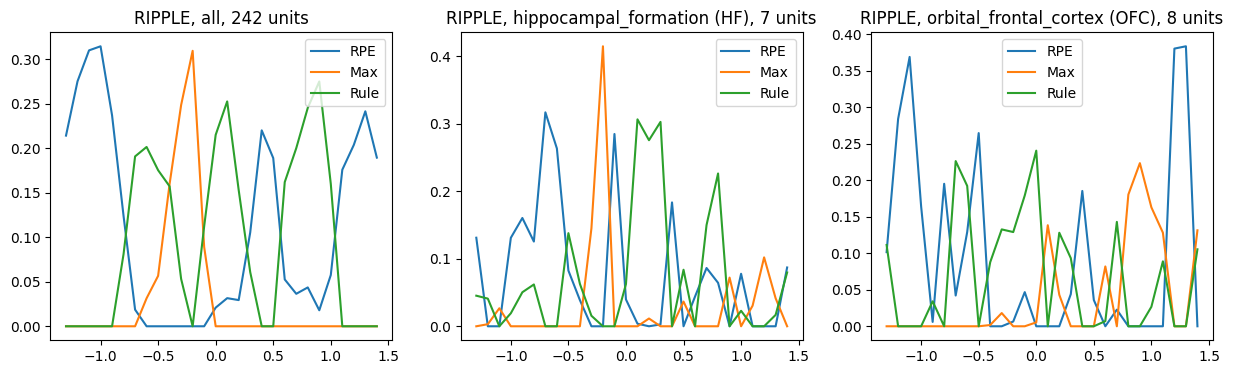

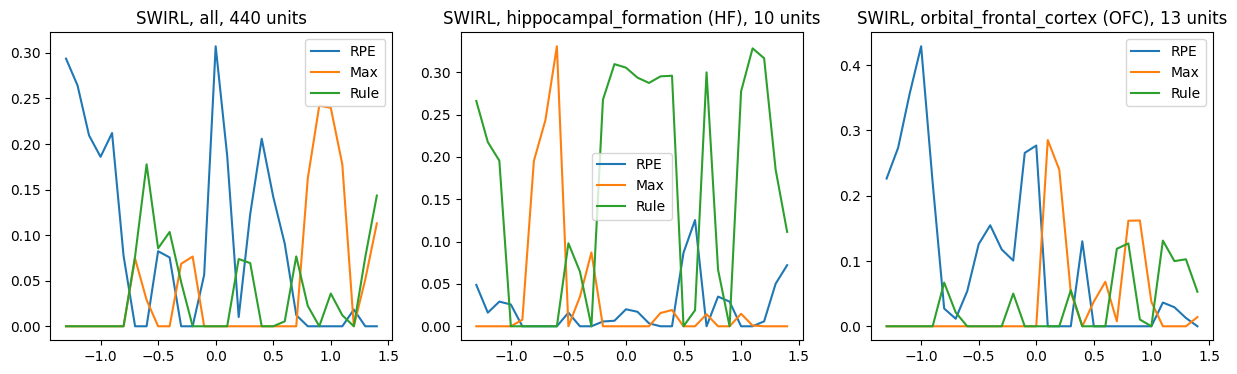

In [19]:
# REGION = "hippocampal_formation (HF)"
# REGION = "orbital_frontal_cortex (OFC)"
REGIONS = ["all", "hippocampal_formation (HF)", "orbital_frontal_cortex (OFC)"]
both_vars = ["RPE", "Max"]
all_vars = ["RPE", "Max", "Rule"]

for feature in FEATURES: 
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for i, region in enumerate(REGIONS):
        if region == "all":
            region_units = units
        elif region == "hippocampal_formation (HF)":
            region_units = units[units.structure_level3 == region]
        else:
            region_units = units[units.structure_level2 == region]
        res = valid_sessions.apply(lambda x: validate_and_label_sessions(x, feature, region_units), axis=1)
        res = res.dropna()
        all_trials = pd.concat(res.values)
        all_trials["Condition"] = all_trials.MaxFeatMatches.astype(str) + " " + all_trials.RPEGroup
        conditions = all_trials.Condition.unique()
        conditions.sort()
        base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("BaseFiringRate").reset_index()
        conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()

        time_bins = np.arange(0, 2.8, 0.1)
        cor_mats = get_cor_mats(conditioned_frs, time_bins)
        data_df = get_data_df(cor_mats, time_bins)

        rpe_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, both_vars, "RPE"))
        max_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, both_vars, "Max"))
        rule_partial_coef = data_df.groupby("TimeBinIdx").apply(lambda group: calc_partial_coef(group, all_vars, "Rule"))

        ax = axs[i]
        ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(rpe_partial_coef.values, np.zeros(len(rpe_partial_coef))), label="RPE")
        ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(max_partial_coef.values, np.zeros(len(max_partial_coef))), label="Max")
        ax.plot(np.arange(-1.3, 1.5, 0.1), np.maximum(rule_partial_coef.values, np.zeros(len(rule_partial_coef))), label="Rule")

        # plt.plot(np.arange(-1.3, 1.5, 0.05), res.values)
        ax.set_title(f"{feature}, {region}, {len(all_trials.PseudoUnitID.unique())} units")
        ax.legend()
        
        
        

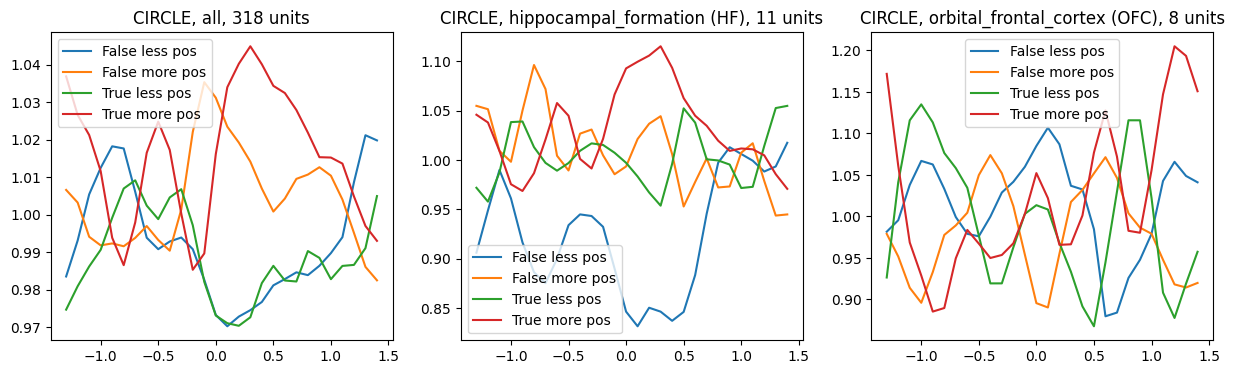

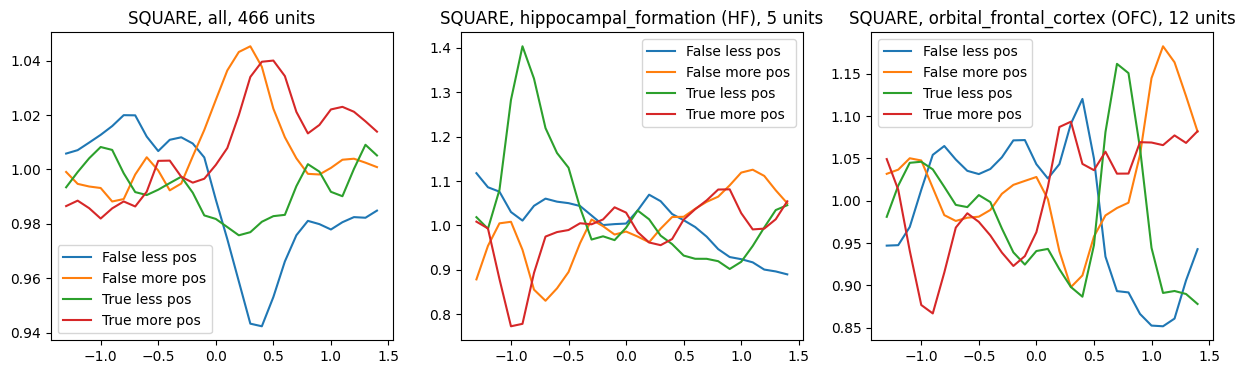

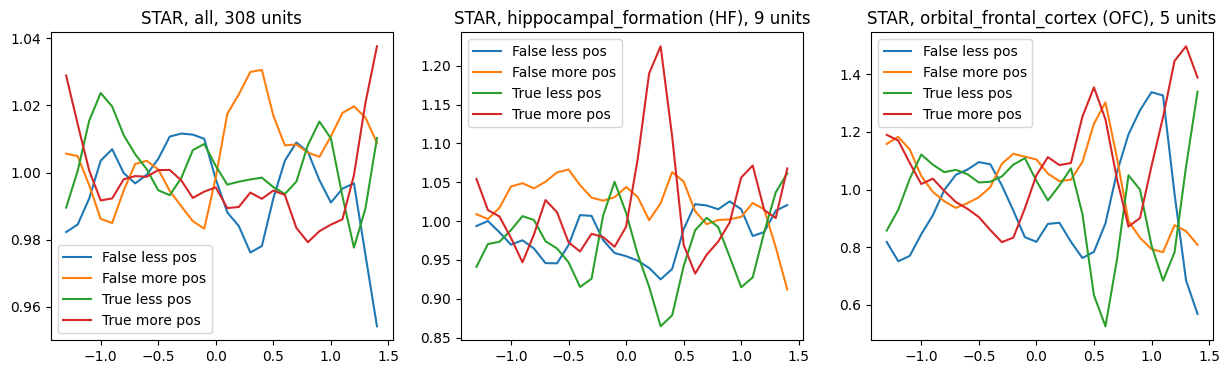

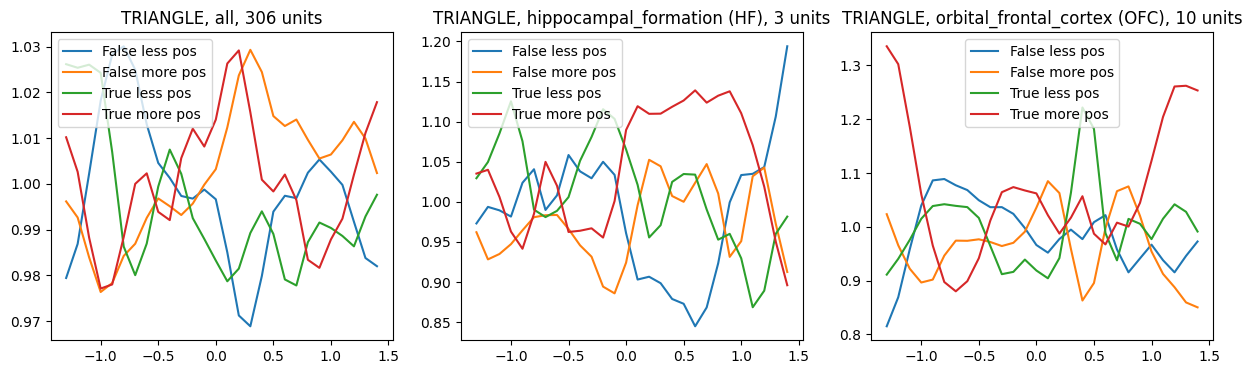

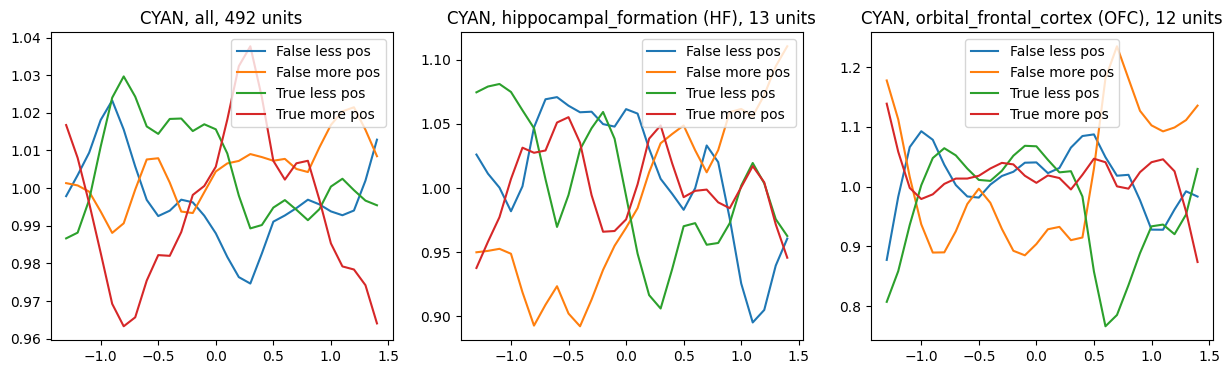

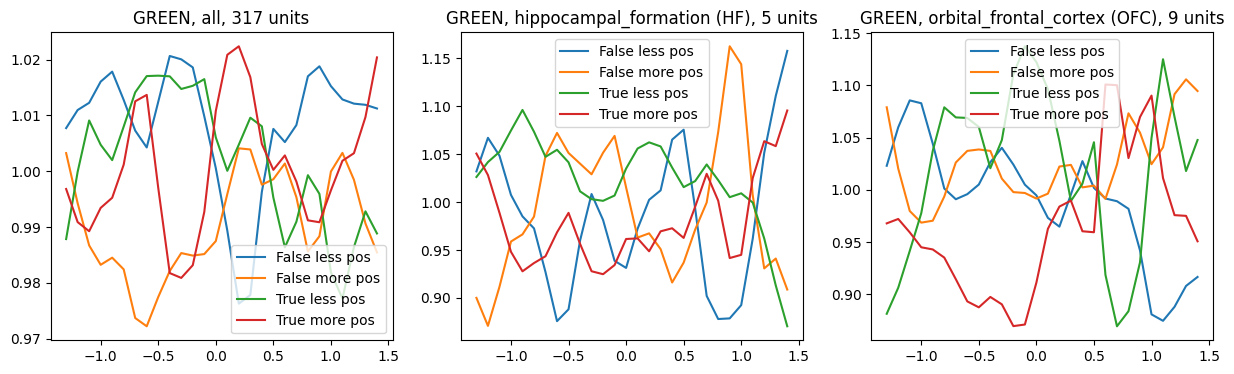

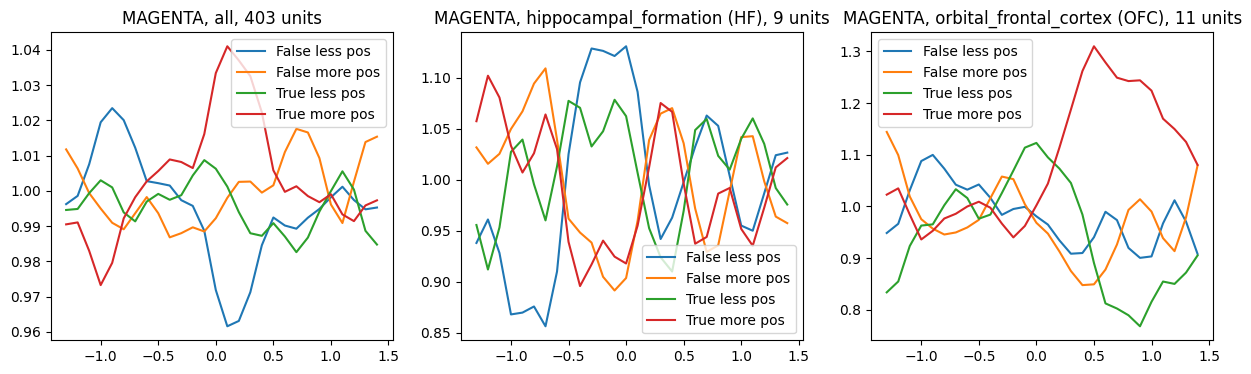

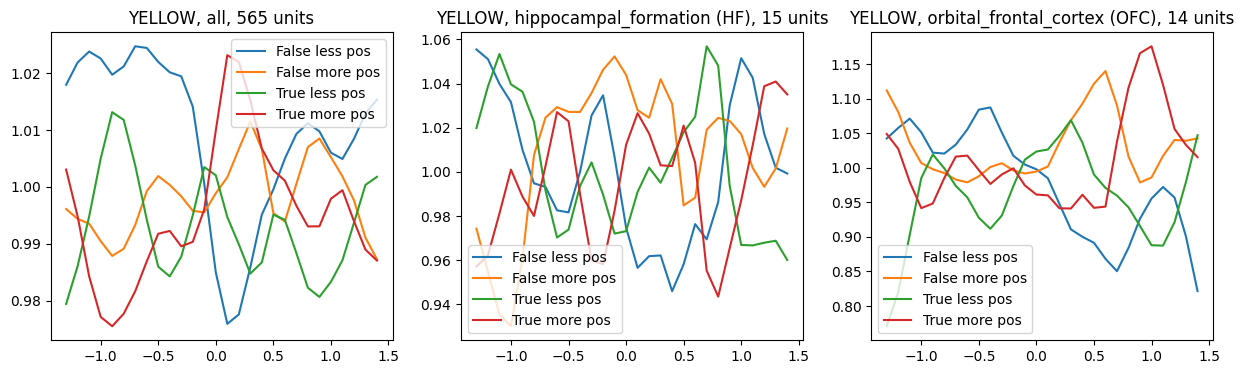

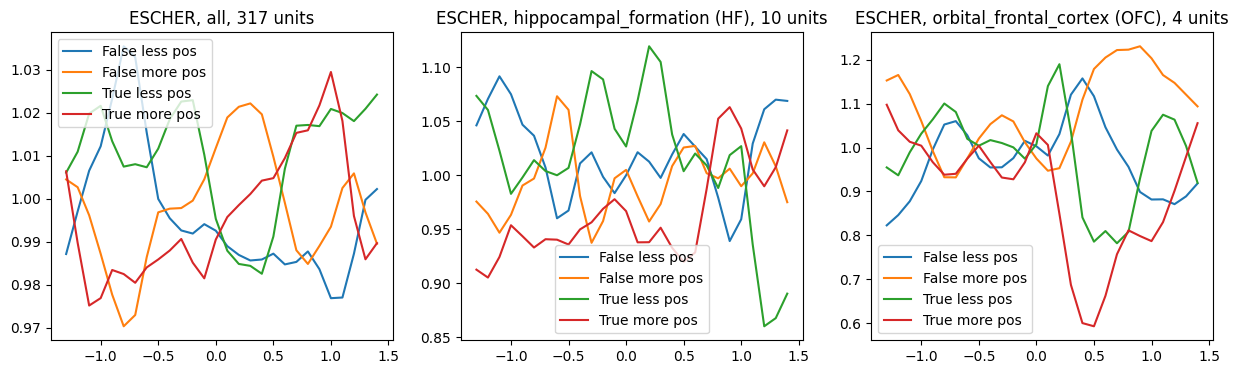

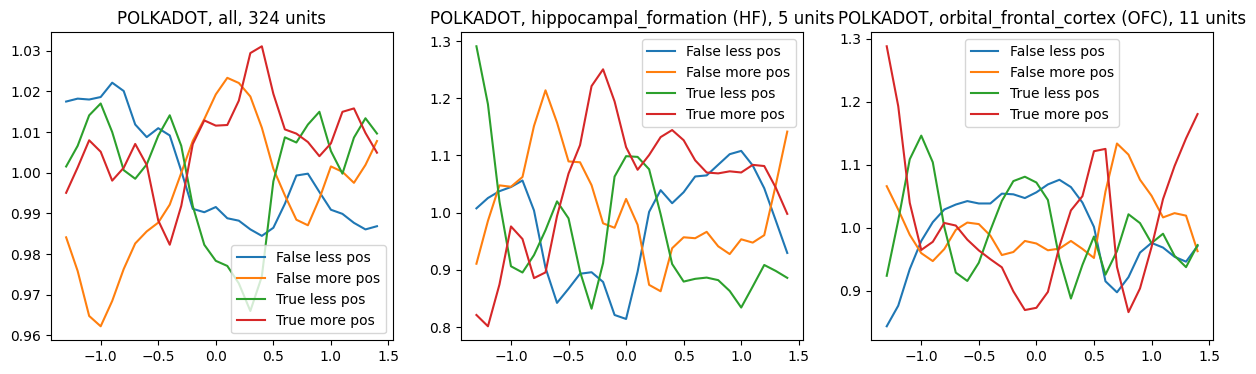

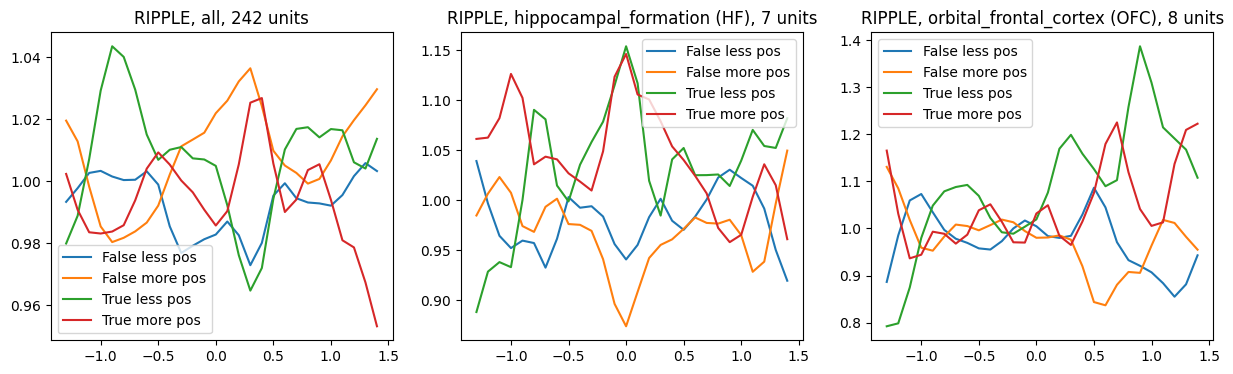

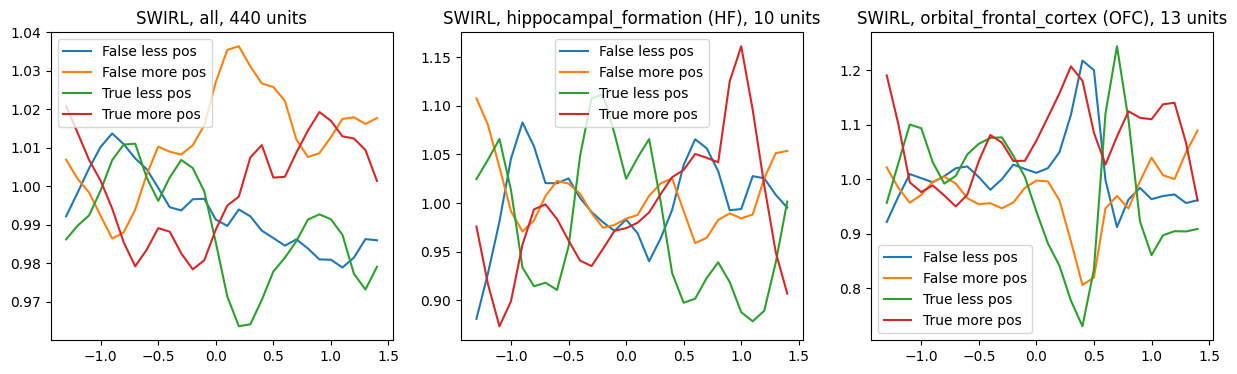

In [20]:
for feature in FEATURES: 
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for i, region in enumerate(REGIONS):
        if region == "all":
            region_units = units
        elif region == "hippocampal_formation (HF)":
            region_units = units[units.structure_level3 == region]
        else:
            region_units = units[units.structure_level2 == region]
        res = valid_sessions.apply(lambda x: validate_and_label_sessions(x, feature, region_units), axis=1)
        res = res.dropna()
        all_trials = pd.concat(res.values)
        all_trials["Condition"] = all_trials.MaxFeatMatches.astype(str) + " " + all_trials.RPEGroup
        conditions = all_trials.Condition.unique()
        conditions.sort()
        base_frs = all_trials.groupby(["PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("BaseFiringRate").reset_index()
        conditioned_frs = all_trials.groupby(["Condition", "PseudoUnitID", "TimeBins"]).FiringRate.mean().to_frame("ConditionedFiringRate").reset_index()
        ax = axs[i]
        for condition in conditions:
            frs = conditioned_frs[conditioned_frs.Condition == condition]
            merged = pd.merge(frs, base_frs, on=["PseudoUnitID", "TimeBins"])
            def calc_proj(group):
                prod = group.ConditionedFiringRate * group.BaseFiringRate
                # base_mag = np.sqrt(np.sum(group.BaseFiringRate ** 2))
                base_mag = np.sum(group.BaseFiringRate ** 2)
                dot = np.sum(prod)
                proj = dot / base_mag
                return proj
            res = merged.groupby("TimeBins").apply(calc_proj).to_frame("Proj").reset_index()
            time = np.arange(-1.3, 1.5, 0.1)
            ax.plot(time, res.Proj, label=condition)
        ax.set_title(f"{feature}, {region}, {len(all_trials.PseudoUnitID.unique())} units")
        ax.legend()